In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
from polyphony.dataset import load_pancreas
from polyphony import Polyphony
from polyphony.utils.visualize import display_umap

Global seed set to 0


# Data Preparation

In this example, we use the `Pancreas` dataset from the [scArches example](https://scarches.readthedocs.io/en/latest/scvi_surgery_pipeline.html). Two batches of the data (`Pancreas CelSeq2` and `Pancreas SS2`) are used as for query. And the rest makes up the reference dataset.

In [3]:
ref, query = load_pancreas()

In [4]:
pp = Polyphony(ref, query, 'pancreas_easy')

# Model Building

### Step-0: setup the data

In [5]:
pp.setup_data()

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 5

### Step-1: build reference model and the initial query model

In [6]:
pp.init_reference_step()

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Pickle of ParametricUMAP model loaded from /Users/chengfurui/Projects/polyphony/data/umap/model.pkl


2022-03-05 17:15:31.070201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras encoder model loaded from /Users/chengfurui/Projects/polyphony/data/umap/encoder
Keras full model loaded from /Users/chengfurui/Projects/polyphony/data/umap/parametric_model


2022-03-05 17:15:31.854804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
... storing 'study' as categorical
... storing 'source' as categorical


<Figure size 800x800 with 0 Axes>

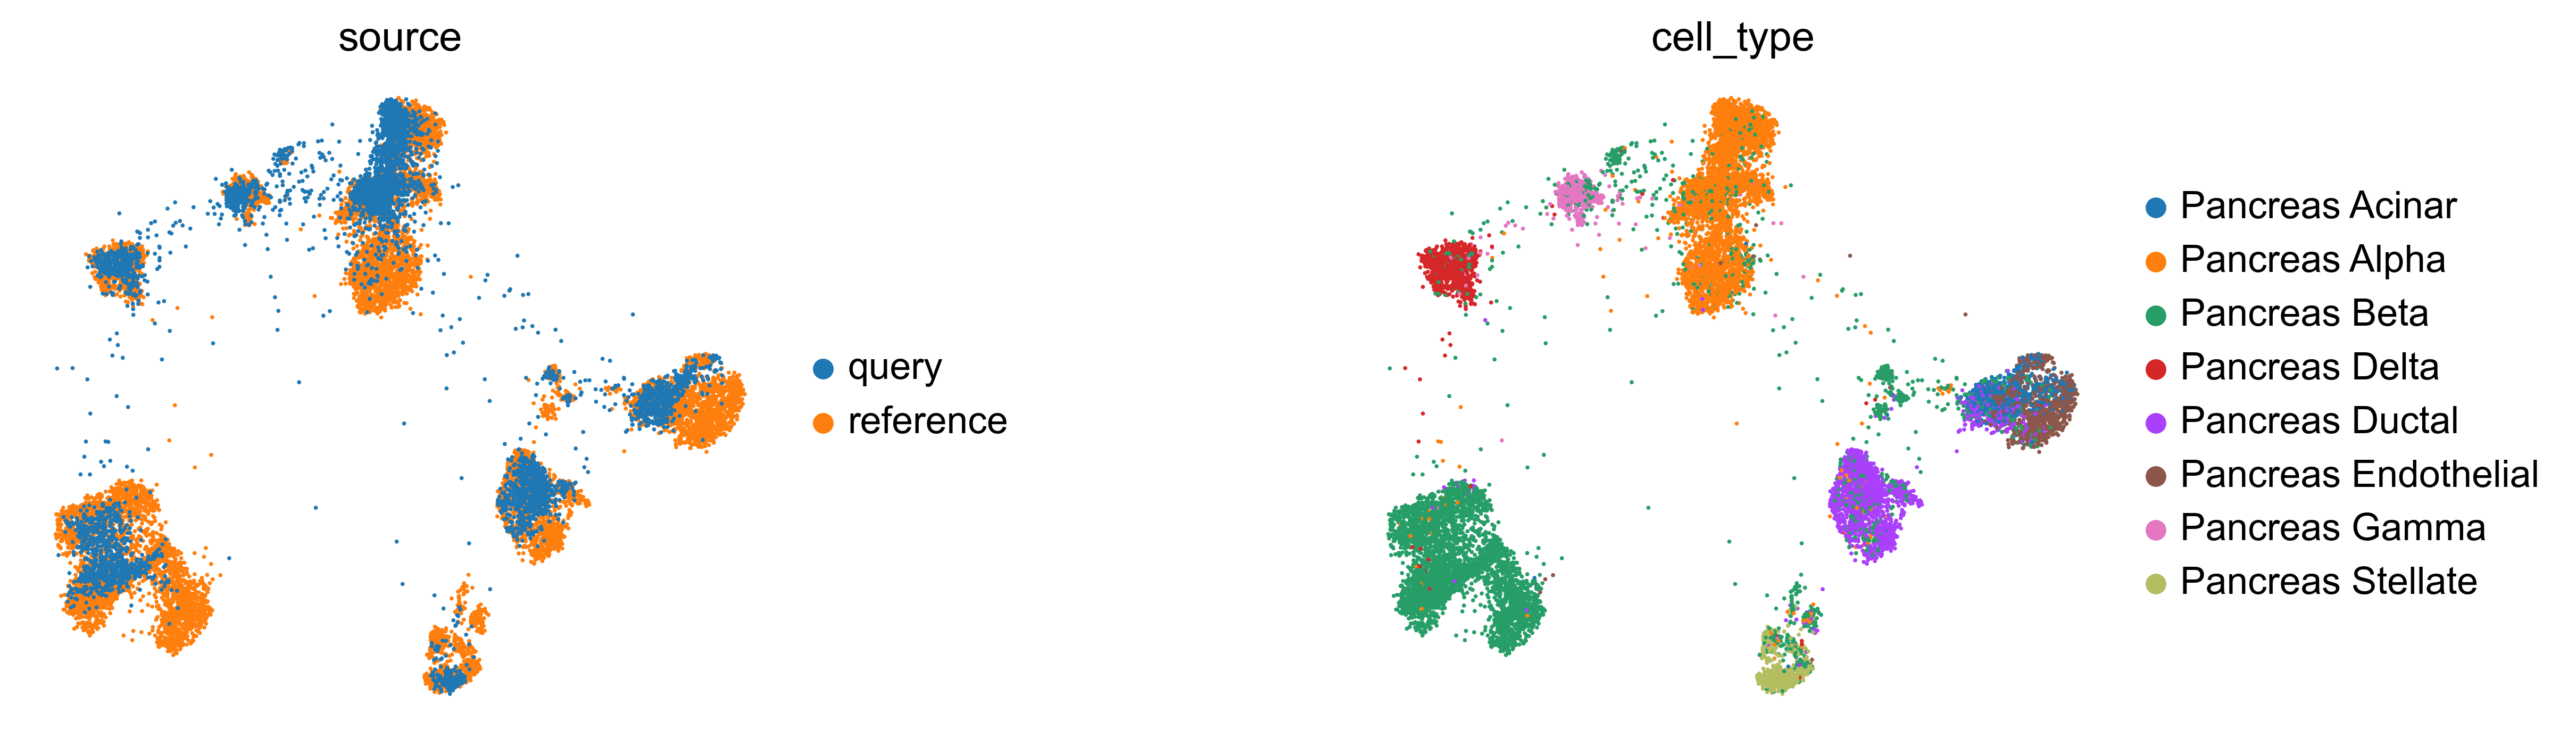

In [7]:
pp.umap_transform()
display_umap(pp.full_adata, color=["source", "cell_type"])

In [8]:
import numpy as np

from harmonypy import compute_lisi

def lisi(adata):
    perplexity = 30
    ilisi = compute_lisi(adata.obsm['latent'], adata.obs, ['source'], perplexity)
    clisi = compute_lisi(adata.obsm['latent'], adata.obs, ['cell_type'], perplexity)

    ilisi_median = np.median(ilisi)
    clisi_median = np.median(clisi)
    return ilisi_median, clisi_median

In [9]:
# lisi(pp.full_adata)

### Step-2: refine the query model 

In [10]:
pp.anchor_recom_step()

2022-03-05 17:15:36,753 - harmonypy - INFO - Iteration 1 of 10
2022-03-05 17:15:39,625 - harmonypy - INFO - Iteration 2 of 10
2022-03-05 17:15:42,594 - harmonypy - INFO - Iteration 3 of 10
2022-03-05 17:15:45,890 - harmonypy - INFO - Iteration 4 of 10
2022-03-05 17:15:49,008 - harmonypy - INFO - Iteration 5 of 10
2022-03-05 17:15:52,263 - harmonypy - INFO - Iteration 6 of 10
2022-03-05 17:15:55,408 - harmonypy - INFO - Iteration 7 of 10
2022-03-05 17:15:58,428 - harmonypy - INFO - Iteration 8 of 10
2022-03-05 17:16:01,469 - harmonypy - INFO - Iteration 9 of 10
2022-03-05 17:16:03,913 - harmonypy - INFO - Iteration 10 of 10
2022-03-05 17:16:06,247 - harmonypy - INFO - Converged after 10 iterations


In [13]:
anchor_mat = pp.query_dataset.anchor_mat > 0.3
pp.anchor_update_step(anchor_mat)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cell_update', 'desired_rep']      
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|█████████████████████████████████████████████████████████| 400/400 [04:55<00:00,  1.35it/s, loss=1.19e+03, v_num=1]


... storing 'study' as categorical
... storing 'source' as categorical


<Figure size 800x800 with 0 Axes>

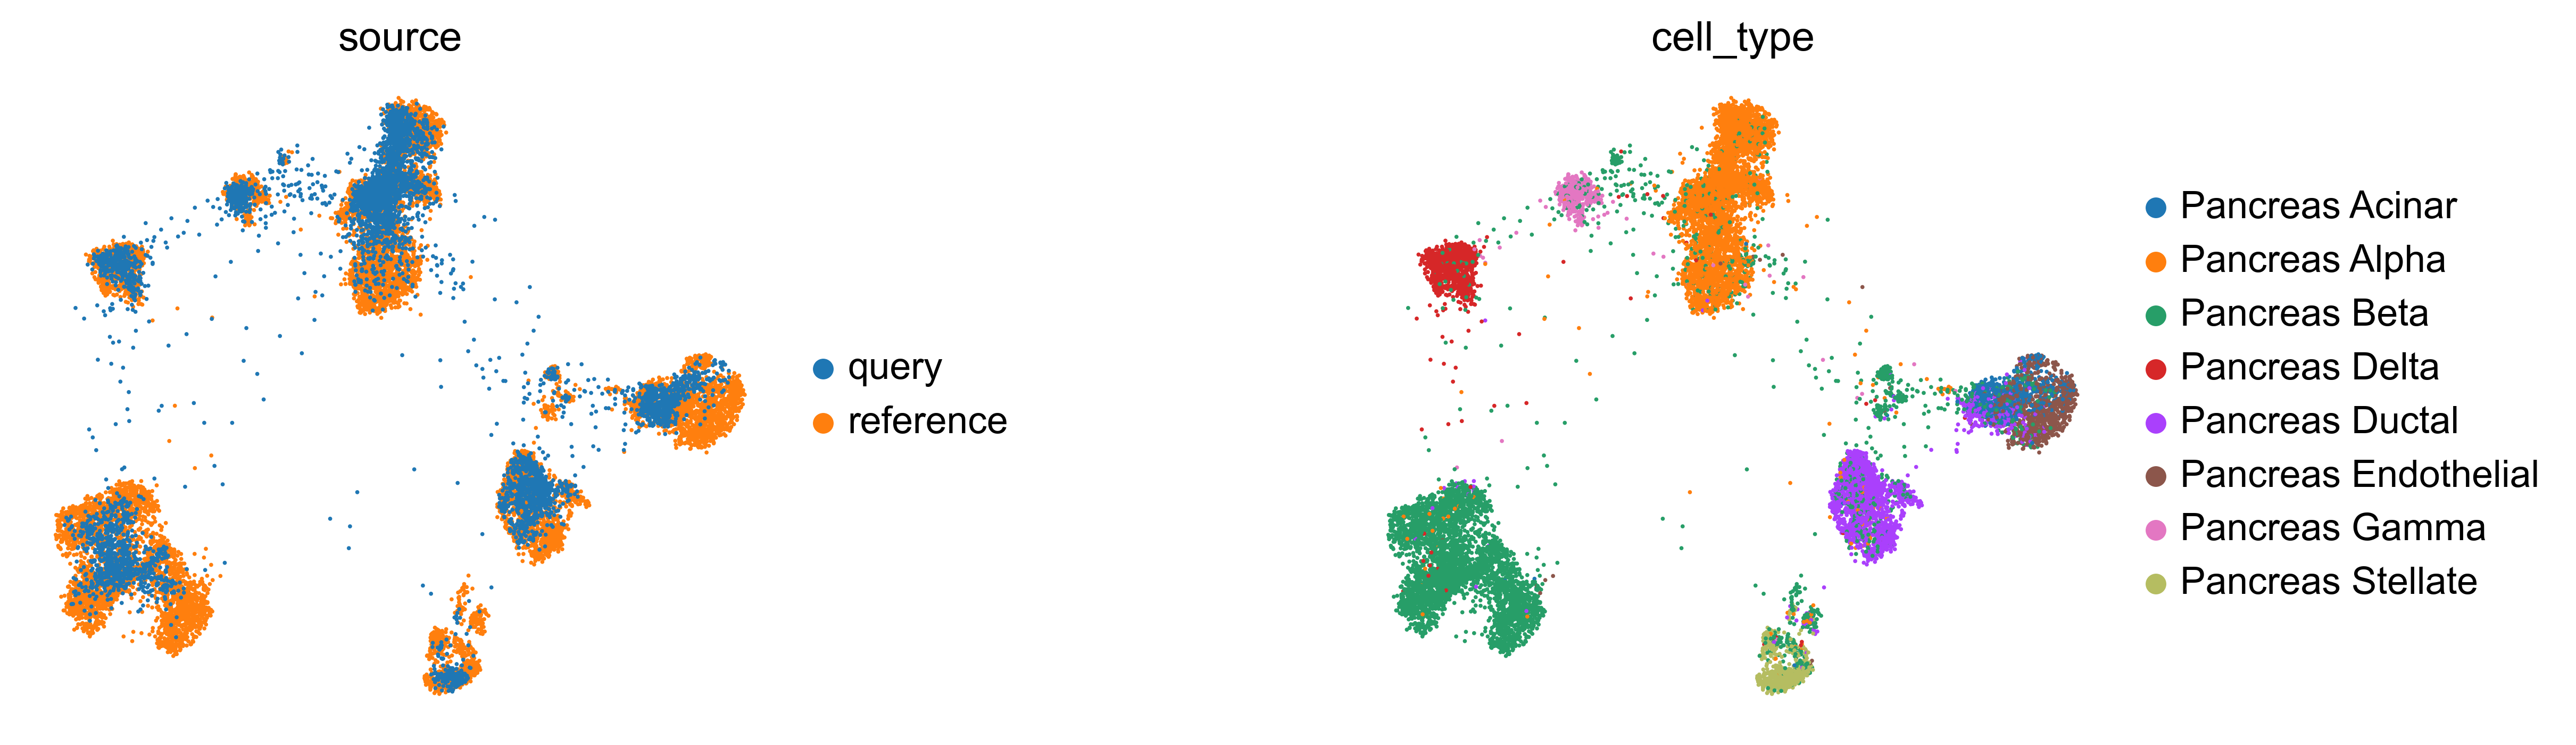

In [14]:
pp.umap_transform(udpate_reference=False)
display_umap(pp.full_adata, color=["source", "cell_type"])